<a href="https://colab.research.google.com/github/Abdulhamid97Mousa/Hand_Signs_Data/blob/main/Hands_Signs_Image_Classification_Transfer_Learning_VGG16_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Dataset: Hand_Signs_From 0 to 9**
The dataset is comprised of hand_signs.
So we have 10 categories.
`0, 1, 2, 3, 4, 5, 6, 7, 8, 9`

In [1]:
import errno, os
import requests
import scipy.io as sio
import numpy as np

from os import listdir
from os.path import isfile, join
from zipfile import ZipFile 
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.modules.loss import CrossEntropyLoss
from torchvision import transforms, datasets, models
from torch import optim, cuda
from torch.utils.data import  sampler

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Others
from IPython.core.debugger import set_trace
from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(os.getcwd())
filename = os.path.join(os.getcwd(), 'repo.zip')
print(filename)

/content
/content/repo.zip


In [4]:
filename = os.path.join(os.getcwd(), 'repo.zip')
url = 'https://github.com/Abdulhamid97Mousa/Hand_Signs_Data/archive/refs/heads/main.zip'


r = requests.get(url)
print(filename)
with open(filename, 'wb') as f:
    f.write(r.content)


file_name = "/content/repo.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Finished Extracting!') 

/content/repo.zip
Extracting all the files now...
Finished Extracting!


In [5]:
def create_dir(dir):
  if not os.path.exists(dir):
    os.makedirs(dir)
    print("Created Directory : ", dir)
  else:
    print("Directory already existed : ", dir)
  return dir

In [6]:
data = create_dir("/content/Data")

Created Directory :  /content/Data


In [7]:
file_name = "/content/Hand_Signs_Data-main/gesture_images.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
  
    # extracting all the files 
    print('Extracting all the files now...')
    zip.extractall(data) 
    print('Finished Extracting!') 

Extracting all the files now...
Finished Extracting!


In [8]:
from matplotlib import image
from matplotlib import pyplot
import matplotlib.pyplot as plt
from PIL import Image

In [9]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [10]:
# ------------------ getting image files -------------------- #
A_0 = load_images('/content/Data/A0')
A_1 = load_images('/content/Data/A1')
A_2 = load_images('/content/Data/A2')
A_3 = load_images('/content/Data/A3')
A_4 = load_images('/content/Data/A4')
A_5 = load_images('/content/Data/A5')
A_6 = load_images('/content/Data/A6')
A_7 = load_images('/content/Data/A7')
A_8 = load_images('/content/Data/A8')
A_9 = load_images('/content/Data/A9')

In [11]:
# --------------------- knowing the number of images in each file ----------- #
print(len(A_0))
print(len(A_1))
print(len(A_2))
print(len(A_3))
print(len(A_4))
print(len(A_5))
print(len(A_6))
print(len(A_7))
print(len(A_8))
print(len(A_9))

159
160
160
160
160
160
160
160
160
160


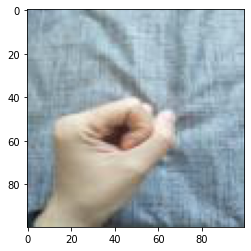

In [12]:
# load image as pixel array
single_image = Image.open('/content/Data/A0/00009.jpg')
# summarize shape of the pixel array
single_image = np.array(single_image)
plt.imshow(single_image)

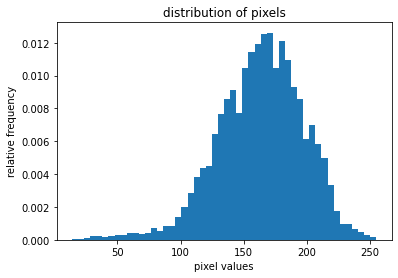

In [13]:
single_image_1 = Image.open('/content/Data/A0/00009.jpg')
plt.hist(np.array(single_image_1).ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")
plt.show()

In [14]:
import torchvision.transforms as transforms

In [15]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
 
 
transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


## **Normalize Pixel Values**
For most image data, the pixel values are integers with values between 0 and 255.

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1.

It is valid for images to have pixel values in the range 0-1 and images can be viewed normally.

This can be achieved by dividing all pixels values by the largest pixel value; that is 255. This is performed across all channels, regardless of the actual range of pixel values that are present in the image.

In [16]:
# example of pixel normalization
from numpy import asarray

In [17]:
def normalize_images_in_folder(IMG_FOLDER):
    images = []
    for img in IMG_FOLDER:
        pixels = asarray(img)
        # convert from integers to floats
        pixels = pixels.astype('float32')
        # normalize to the range 0-1
        pixels = pixels/255
        # confirm the normalization
        # print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
        # calculate global mean and standard deviation
        mean, std = pixels.mean(), pixels.std()
        # global standardization of pixels
        pixels = (pixels - mean) / std
        # confirm it had the desired effect
        mean, std = pixels.mean(), pixels.std()
        # print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
        images.append(pixels)
    return np.array(images).astype(np.float32)

In [18]:
def give_image_a_label(images, label):
    storage = []
    for i in range(images.shape[0]):
        storage.append(label)

    return np.array(storage).astype(np.float32)

In [19]:
A_0 = normalize_images_in_folder(A_0)
print(A_0.shape)
y_0 = give_image_a_label(A_0, 0)
print(A_0[0].shape)
print(y_0[0])

(159, 100, 100, 3)
(100, 100, 3)
0.0


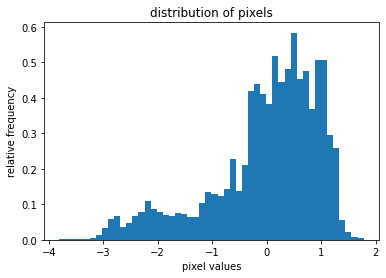

In [20]:
plt.hist(np.array(A_0[1]).ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")
plt.show()

In [21]:
A_1 = normalize_images_in_folder(A_1)
y_1 = give_image_a_label(A_1,1)
print(A_1[0].shape)
print(y_1[0])

A_2 = normalize_images_in_folder(A_2)
y_2 = give_image_a_label(A_2, 2)
print(A_2[0].shape)
print(y_2[0])

A_3 = normalize_images_in_folder(A_3)
y_3 = give_image_a_label(A_3, 3)
print(A_3[0].shape)
print(y_3[0])

A_4 = normalize_images_in_folder(A_4)
y_4 = give_image_a_label(A_4,4)
print(A_4[0].shape)
print(y_4[0])

A_5 = normalize_images_in_folder(A_5)
y_5 = give_image_a_label(A_5,5)
print(A_5[0].shape)
print(y_5[0])

A_6 = normalize_images_in_folder(A_6)
y_6 = give_image_a_label(A_6, 6)
print(A_6[0].shape)
print(y_6[0])

A_7 = normalize_images_in_folder(A_7)
y_7 = give_image_a_label(A_7, 7)
print(A_7[0].shape)
print(y_7[0])


A_8 = normalize_images_in_folder(A_8)
y_8 = give_image_a_label(A_8, 8)
print(A_8[0].shape)
print(y_8[0])


A_9 = normalize_images_in_folder(A_9)
y_9 = give_image_a_label(A_9, 9)
print(A_9[0].shape)
print(y_9[0])

(100, 100, 3)
1.0
(100, 100, 3)
2.0
(100, 100, 3)
3.0
(100, 100, 3)
4.0
(100, 100, 3)
5.0
(100, 100, 3)
6.0
(100, 100, 3)
7.0
(100, 100, 3)
8.0
(100, 100, 3)
9.0


In [22]:
# convert numpy array to torch tensor
A_0 = torch.from_numpy(A_0)
A_1 = torch.from_numpy(A_1)
A_2 = torch.from_numpy(A_2)
A_3 = torch.from_numpy(A_3)
A_4 = torch.from_numpy(A_4)
A_5 = torch.from_numpy(A_5)
A_6 = torch.from_numpy(A_6)
A_7 = torch.from_numpy(A_7)
A_8 = torch.from_numpy(A_8)
A_9 = torch.from_numpy(A_9)

In [23]:
y_0 = torch.from_numpy(y_0)
y_1 = torch.from_numpy(y_1)
y_2 = torch.from_numpy(y_2)
y_3 = torch.from_numpy(y_3)
y_4 = torch.from_numpy(y_4)
y_5 = torch.from_numpy(y_5)
y_6 = torch.from_numpy(y_6)
y_7 = torch.from_numpy(y_7)
y_8 = torch.from_numpy(y_8)
y_9 = torch.from_numpy(y_9)

In [24]:
# concatenate the data of normal, ball, inner_race, outer_race
X = torch.cat((A_0, A_1, A_2, A_3, A_4, A_5, A_6, A_7, A_8, A_9), dim=0)
print(X.shape)

torch.Size([1599, 100, 100, 3])


In [25]:
# concatenate the label data of normal, ball, inner_race, outer_race
y = torch.cat((y_0, y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9), dim=0)
print(y.shape)

torch.Size([1599])


In [26]:
train = X
test = y
print(train.shape)
print(test.shape)

torch.Size([1599, 100, 100, 3])
torch.Size([1599])


In [27]:
# set aside 20% of train and test data for evaluation
X_train, X_val, y_train, y_val = train_test_split(train, test,
    test_size=0.2, shuffle = True, random_state = 8)
print("X_train shape: {}, dtype: {}".format(X_train.shape, type(X_train)))
print("y_train shape: {}".format(y_train.shape))
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
#     test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print("X_train shape: {}, dtype: {}".format(X_train.shape, type(X_train)))
# print("y_train shape: {}".format(y_train.shape))

X_train shape: torch.Size([1279, 100, 100, 3]), dtype: <class 'torch.Tensor'>
y_train shape: torch.Size([1279])


In [28]:
print("X_train shape: {}, dtype: {}".format(X_train.shape, type(X_train)))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))
# print("X_test shape: {}".format(X_test.shape))
# print("y_test shape: {}".format(y_test.shape))

X_train shape: torch.Size([1279, 100, 100, 3]), dtype: <class 'torch.Tensor'>
y_train shape: torch.Size([1279])
X_val shape: torch.Size([320, 100, 100, 3])
y_val shape: torch.Size([320])


In [29]:
# Functions for training
def get_dataloader(train_ds, valid_ds, bs):
    '''
        Get dataloaders of the training and validation set.
        Parameter:
            train_ds: Dataset
                Training set
            valid_ds: Dataset
                Validation set
            bs: Int
                Batch size

        Return:
            (train_dl, valid_dl): Tuple of DataLoader
                Dataloaders of training and validation set.
    '''
    return (
        DataLoader(train_ds, batch_size=bs, drop_last=True, shuffle=True),
        DataLoader(valid_ds, batch_size=bs, drop_last=True, shuffle=True),
        #DataLoader(test_ds, batch_size=bs, drop_last=True)
    )


In [30]:
## Create DataLoader of train and validation set
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train).type(torch.LongTensor)
y_valid = torch.tensor(y_val).type(torch.LongTensor)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test).type(torch.LongTensor)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct 

In [31]:
from torch.utils.data import Dataset, TensorDataset

In [32]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


In [33]:
def imshow(img, title=''):
    """Plot the image batch.
    """
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.numpy(), (1, 2, 0)), cmap='gray')
    plt.show()

In [34]:
def hflip(tensor):
    """Flips tensor horizontally.
    """
    tensor = tensor.flip(2)
    return tensor

In [35]:
# add channel dimesion
X_train = X_train.permute(0, 3, 1, 2)
X_valid = X_valid.permute(0, 3, 1, 2)
# X_test = X_test.permute(0, 3, 1, 2)

print(X_train.shape)
print(X_valid.shape)
# print(X_test.shape)

train_ds = CustomTensorDataset(tensors=(X_train, y_train), transform=transform)
valid_ds = CustomTensorDataset(tensors = (X_valid, y_valid), transform=transform)
# test_ds = CustomTensorDataset(tensors = (X_test, y_test), transform=transform)

torch.Size([1279, 3, 100, 100])
torch.Size([320, 3, 100, 100])


In [36]:
# bs = batchsize = 64 as defined in the hyperparameters "look at the above cell"
batch_size = 16
train_dl, valid_dl = get_dataloader(train_ds, valid_ds, batch_size)


## **Image Preprocessing**
To prepare the images for our network, we have to resize them to 64 x 64 and normalize each color channel by subtracting a mean value and dividing by a standard deviation. We will also augment our training data in this stage. These operations are done using image transforms, which prepare our data for a neural network.

### **Data Augmentation**
Because there are a limited number of images in some categories, we can use image augmentation to artificially increase the number of images "seen" by the network. This means for training, we randomly resize and crop the images and also flip them horizontally. A different random transformation is applied each epoch (while training), so the network effectively sees many different versions of the same image. All of the data is also converted to Torch Tensors before normalization. The validation and testing data is not augmented but is only resized and normalized. The normalization values are standardized for Imagenet.

We'll work with two example images and apply the train transformations.

## **Data Iterators**
To avoid loading all of the data into memory at once, we use training DataLoaders. First, we create a dataset object from the image folders, and then we pass these to a DataLoader. At training time, the DataLoader will load the images from disk, apply the transformations, and yield a batch. To train and validation, we'll iterate through all the batches in the respective DataLoader.

One crucial aspect is to shuffle the data before passing it to the network. This means that the ordering of the image categories changes on each pass through the data (one pass through the data is one training epoch).

## **Importing and training the model**
The pre-trained model can be imported using Pytorch. The device can further be transferred to use GPU, which can reduce the training time.

The dataset is further divided into training and validation set to avoid overfitting. Some parameters used in this model while training is as follows:

Criterion- Crossentropy loss
optimiser- Stochastic gradient descent, learning rate=0.01, momentum=0.9
Exponential Learning rate scheduler- This reduces the value of learning rate every 7 steps by a factor of gamma=0.1.
A linear fully connected layer is added in the end to converge the output to give two predicted labels.

In [37]:
import torchvision.models as models

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)


In [39]:
for param in model.features.parameters():
    param.requires_grad = False

In [40]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [64]:
import torch.nn as nn

n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [66]:
epochs = 3
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in train_dl:
    inputs = torch.from_numpy(np.array(inputs)).to(device)
    labels = torch.from_numpy(np.array(labels)).to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
 
  else:
    with torch.no_grad():
      for val_inputs, val_labels in valid_dl:
        val_inputs = torch.from_numpy(np.array(val_inputs)).to(device)
        val_labels = torch.from_numpy(np.array(val_labels)).to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(train_dl.dataset)
    epoch_acc = running_corrects.float()/ len(train_dl.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(valid_dl.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(valid_dl.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.1355, acc 0.1470 
validation loss: 0.1105, validation acc 0.2938 
epoch : 2
training loss: 0.0720, acc 0.5434 
validation loss: 0.0678, validation acc 0.6344 
epoch : 3
training loss: 0.0374, acc 0.7647 
validation loss: 0.0359, validation acc 0.7750 


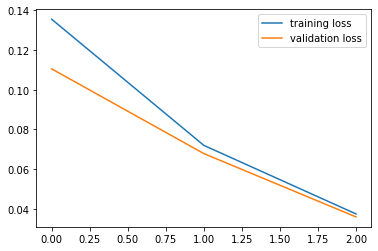

In [67]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

TypeError: ignored

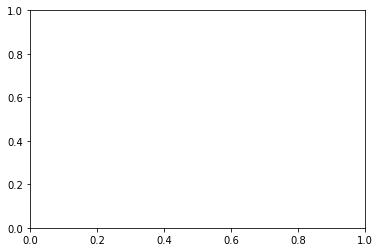

In [69]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()